# Modality Gap in CLIP


In [2]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ac7jyy88
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ac7jyy88
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=24a5f95b6909430e9ffd3258bde0b5cf8370e18391fe30747d175d4c2eeb5f37
  Stored in directory: /tmp/pip-ephem-wheel-cache-lobaj7g7/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [3]:
import torch
import clip
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import normalize
from scipy.linalg import orthogonal_procrustes


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

# Load STL-10
transform = transforms.Compose([preprocess])
stl10_test = torchvision.datasets.STL10(root="./data", split="test", download=True, transform=transform)
test_loader = DataLoader(stl10_test, batch_size=64, shuffle=False)
classes = stl10_test.classes  # 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 284MiB/s]
100%|██████████| 2.64G/2.64G [02:45<00:00, 15.9MB/s]


## Zero Shot Classification


In [5]:
def get_prompts(label, style="plain"):
    if style == "plain":
        return label
    elif style == "prompted":
        return f"a photo of a {label}"
    elif style == "descriptive":
        return f"a high-quality image showing a {label} in the wild"
    else:
        raise ValueError("Unknown style")

def zero_shot_accuracy(loader, prompt_type="plain"):
    text_features_list, labels_list = [], []

    # Create text embeddings
    text_inputs = [get_prompts(c, prompt_type) for c in classes]
    text_tokens = clip.tokenize(text_inputs).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ text_features.T
            pred = logits.argmax(dim=-1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Test three prompting strategies
for prompt_style in ["plain", "prompted", "descriptive"]:
    acc = zero_shot_accuracy(test_loader, prompt_style)
    print(f"Zero-shot accuracy ({prompt_style} prompts): {acc:.4f}")


Zero-shot accuracy (plain prompts): 0.9626
Zero-shot accuracy (prompted prompts): 0.9736
Zero-shot accuracy (descriptive prompts): 0.9719


## Exploring the Modality Gap

In [15]:
subset_loader = DataLoader(stl10_test, batch_size=100, shuffle=True)
images, labels = next(iter(subset_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_inputs = [get_prompts(stl10_test.classes[l], "plain") for l in labels]
    text_tokens = clip.tokenize(text_inputs).to(device)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


## Dimensionality reduction & visualization:

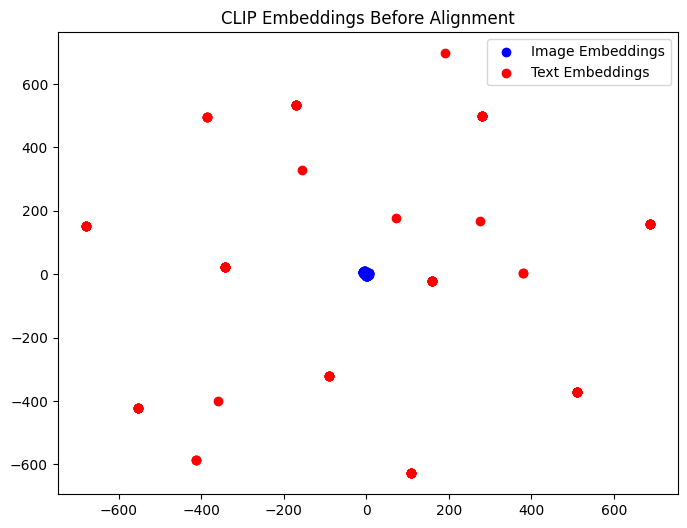

In [16]:
img_feats = image_features.cpu().numpy()
txt_feats = text_features.cpu().numpy()

# --- Part 2: t-SNE Visualization (Modality Gap) ---
tsne_img = TSNE(n_components=2, random_state=42).fit_transform(img_feats)
tsne_txt = TSNE(n_components=2, random_state=42).fit_transform(txt_feats)

plt.figure(figsize=(8,6))
plt.scatter(tsne_img[:,0], tsne_img[:,1], c='blue', label='Image Embeddings')
plt.scatter(tsne_txt[:,0], tsne_txt[:,1], c='red', label='Text Embeddings')
plt.title("CLIP Embeddings Before Alignment")
plt.legend()
plt.show()

## Bridging the Modality Gap

### Orthogonal Procrustes alignment

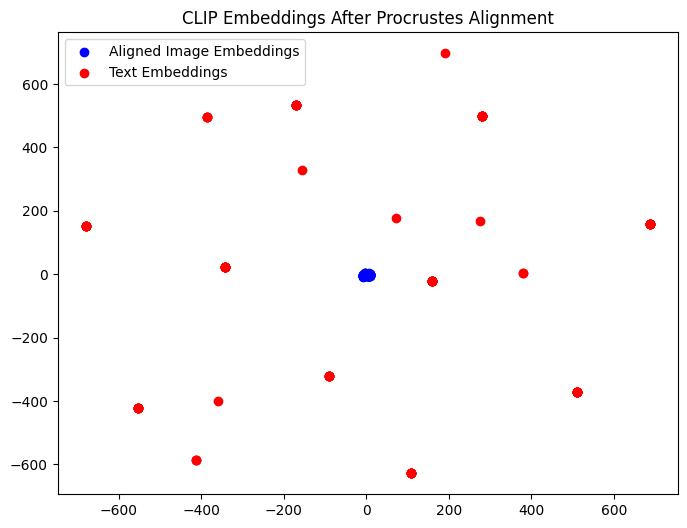

Average cosine similarity before alignment: 0.2539
Average cosine similarity after alignment: 0.8678


In [17]:
R, _ = orthogonal_procrustes(img_feats, txt_feats)
img_aligned = img_feats @ R

# t-SNE visualization after alignment
tsne_aligned = TSNE(n_components=2, random_state=42).fit_transform(img_aligned)
plt.figure(figsize=(8,6))
plt.scatter(tsne_aligned[:,0], tsne_aligned[:,1], c='blue', label='Aligned Image Embeddings')
plt.scatter(tsne_txt[:,0], tsne_txt[:,1], c='red', label='Text Embeddings')
plt.title("CLIP Embeddings After Procrustes Alignment")
plt.legend()
plt.show()

# Optional: cosine similarity before and after
from sklearn.metrics.pairwise import cosine_similarity
sim_before = np.mean([cosine_similarity(img_feats[i:i+1], txt_feats[i:i+1])[0][0] for i in range(len(img_feats))])
sim_after = np.mean([cosine_similarity(img_aligned[i:i+1], txt_feats[i:i+1])[0][0] for i in range(len(img_feats))])

print(f"Average cosine similarity before alignment: {sim_before:.4f}")
print(f"Average cosine similarity after alignment: {sim_after:.4f}")

## Recompute classification with aligned embeddings:

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


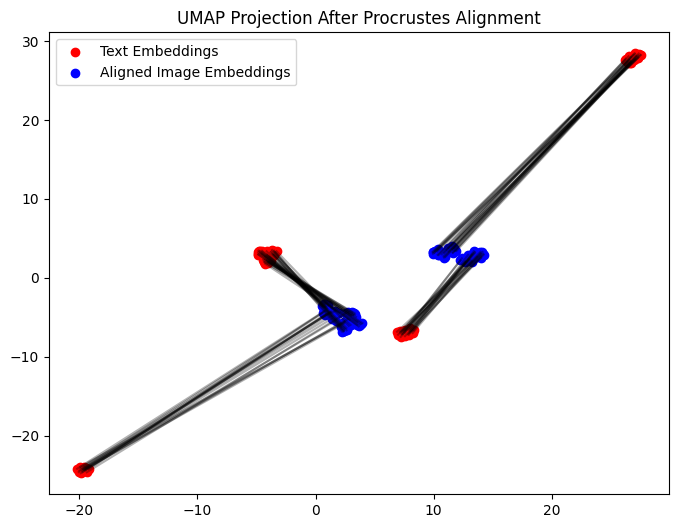

In [18]:

# UMAP projection
umap_model = umap.UMAP(n_components=2, random_state=42)
img_umap = umap_model.fit_transform(img_feats)
txt_umap = umap_model.fit_transform(txt_feats)
img_aligned_umap = umap_model.fit_transform(img_aligned)

plt.figure(figsize=(8,6))
plt.scatter(txt_umap[:,0], txt_umap[:,1], c='red', label='Text Embeddings')
plt.scatter(img_aligned_umap[:,0], img_aligned_umap[:,1], c='blue', label='Aligned Image Embeddings')

# Connect paired points
for i in range(len(img_feats)):
    plt.plot([txt_umap[i,0], img_aligned_umap[i,0]],
             [txt_umap[i,1], img_aligned_umap[i,1]], 'k-', alpha=0.3)

plt.title("UMAP Projection After Procrustes Alignment")
plt.legend()
plt.show()
